In [86]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch

In [68]:
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

In [69]:
for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(im))
im.head()

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580


In [70]:
gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55, 65])
gdp.columns = ['Birthplace', 'GDP11', 'GDP21']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55, 64])
life.columns = ['LE11', 'LE20']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55, 63])
inflation.columns = ['IF11', 'IF19']
unemployment = pd.read_csv("Datasets/unemployment.csv", skiprows=4, usecols=[56, 64])
unemployment.columns = ['UE12', 'UE20']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55, 63])
health.columns = ['HE11', 'HE19']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55, 64])
education.columns = ['ED11', 'ED20']

In [71]:
comb = pd.concat([gdp, life, inflation, unemployment, health, education], axis=1)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,GDP21,LE11,LE20,IF11,IF19,UE12,UE20,HE11,HE19,ED11,ED20
0,Aruba,26044.435933,29342.100858,75.465000,75.723000,4.316297,4.257462,NaN,NaN,NaN,NaN,6.11913,NaN
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,63.313856,8.971206,4.120246,NaN,NaN,6.774233,6.272034,4.38598,4.608170
2,Afghanistan,621.912311,368.754614,61.419000,62.575000,11.804186,2.302373,1.69,11.71,8.561907,13.242202,3.46201,2.860859
3,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,1.758565,NaN,NaN,3.547476,3.366086,2.66890,3.173885
4,Angola,4511.153227,1953.533757,57.596000,62.261000,13.482468,17.079704,NaN,NaN,2.645608,2.533360,3.03000,2.415200


In [72]:
def imputation (file, data, col1, col2):
    f = pd.read_csv(file, skiprows=4, usecols=range(35, 66)).to_numpy()  # 1991-2021

    for i in range(len(data)):
        if math.isnan(data.iloc[[i], [col1]].values) or math.isnan(data.iloc[[i], [col2]].values):
            row = []
            for j in f[i]:
                if not math.isnan(j):
                    row.append(j)

            if len(row) >= 10:
                data.iloc[[i], [col1]] = row[len(row) - 10]
                data.iloc[[i], [col2]] = row[-1]
            elif 1 < len(row) < 10:
                data.iloc[[i], [col1]] = row[0]
                data.iloc[[i], [col2]] = row[-1]
            row.clear()


imputation("Datasets/gdp.csv", comb, 1, 2)
imputation("Datasets/life.csv", comb, 3, 4)
imputation("Datasets/inflation.csv", comb, 5, 6)
imputation("Datasets/unemployment.csv", comb, 7, 8)
imputation("Datasets/health.csv", comb, 9, 10)
imputation("Datasets/education.csv", comb, 11, 12)

comb.dropna(axis=0,subset = ['GDP11', 'GDP21', 'LE11', 'LE20', 'IF11', 'IF19', 'UE12', 'UE20', 'HE11', 'HE19', 'ED11', 'ED20'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 205


,Birthplace,GDP11,GDP21,LE11,LE20,IF11,IF19,UE12,UE20,HE11,HE19,ED11,ED20
0,Afghanistan,621.912311,368.754614,61.419000,62.575000,11.804186,2.302373,1.690000,11.710000,8.561907,13.242202,3.46201,2.860859
1,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,1.758565,4.339628,6.980368,3.547476,3.366086,2.66890,3.173885
2,Albania,4437.142612,6492.872012,78.092000,76.989000,3.429123,1.411091,13.380000,11.690000,4.602225,5.232072,3.08000,3.100000
3,Algeria,5473.280550,3690.627878,74.123000,74.453000,4.524212,1.951768,11.330000,12.000000,5.267481,6.243371,6.03000,7.042397
4,Angola,4511.153227,1953.533757,57.596000,62.261000,13.482468,17.079704,23.639999,9.580000,2.645608,2.533360,3.03000,2.415200


In [73]:
def increase_rate(num1, num2):
    return float(format((num2 - num1) / num1, '.4f'))

a, b, c, d, e, f, g, h = [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:
            a.append(im['Birthplace'][n])
            b.append(im['2011-2021'][n])
            c.append(increase_rate(comb['GDP11'][m], comb['GDP21'][m]))
            d.append(increase_rate(comb['LE20'][m], comb['LE11'][m]))
            e.append(increase_rate(comb['IF11'][m], comb['IF19'][m]))
            f.append(increase_rate(comb['UE12'][m], comb['UE20'][m]))
            g.append(increase_rate(comb['HE11'][m], comb['HE19'][m]))
            h.append(increase_rate(comb['ED11'][m], comb['ED20'][m]))

dataset = pd.DataFrame({'Birthplace':a, 'Immigration':b, 'GDP_Change':c, 'LE_Change':d, 'IF_Change': e, 'UE_Change': f, 'HE_Change': g, 'ED_Change': h})
print("Number of country/region:", len(dataset))
dataset.head()

Number of country/region: 138


,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,UE_Change,HE_Change,ED_Change
0,Afghanistan,21340,-0.4071,-0.0185,-0.8050,5.9290,0.5466,-0.1736
1,Albania,5500,0.4633,0.0143,-0.5885,-0.1263,0.1369,0.0065
2,Algeria,32580,-0.3257,-0.0044,-0.5686,0.0591,0.1853,0.1679
3,Angola,580,-0.5670,-0.0749,0.2668,-0.5948,-0.0424,-0.2029
4,Antigua and Barbuda,365,0.2031,-0.0220,-0.5859,0.4033,-0.1837,0.5436


In [74]:
nor = normalize([dataset['Immigration']])
dataset['Immigration'] = nor[0][:]
dataset.head()

,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,UE_Change,HE_Change,ED_Change
0,Afghanistan,0.036370,-0.4071,-0.0185,-0.8050,5.9290,0.5466,-0.1736
1,Albania,0.009374,0.4633,0.0143,-0.5885,-0.1263,0.1369,0.0065
2,Algeria,0.055526,-0.3257,-0.0044,-0.5686,0.0591,0.1853,0.1679
3,Angola,0.000988,-0.5670,-0.0749,0.2668,-0.5948,-0.0424,-0.2029
4,Antigua and Barbuda,0.000622,0.2031,-0.0220,-0.5859,0.4033,-0.1837,0.5436


In [75]:
dataset.describe()

,Immigration,GDP_Change,LE_Change,IF_Change,UE_Change,HE_Change,ED_Change
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.024208,0.192912,-0.023028,0.048496,0.818932,0.090400,0.128370
std,0.081908,0.406335,0.034303,6.313852,4.709473,0.276899,0.400351
min,0.000017,-0.620800,-0.192600,-3.831700,-0.926400,-0.428700,-0.826800
25%,0.001447,-0.032825,-0.037550,-0.804775,-0.315650,-0.063400,-0.091975
50%,0.004810,0.125200,-0.018300,-0.552850,0.042350,0.048600,0.050400
75%,0.012637,0.374075,-0.002650,-0.258425,0.529550,0.173475,0.244775
max,0.666317,1.927000,0.060300,72.657100,51.633300,1.428300,2.300800


<Axes: >

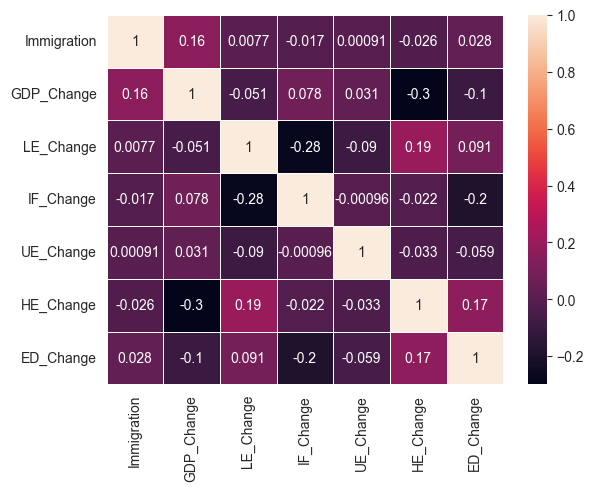

In [76]:
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

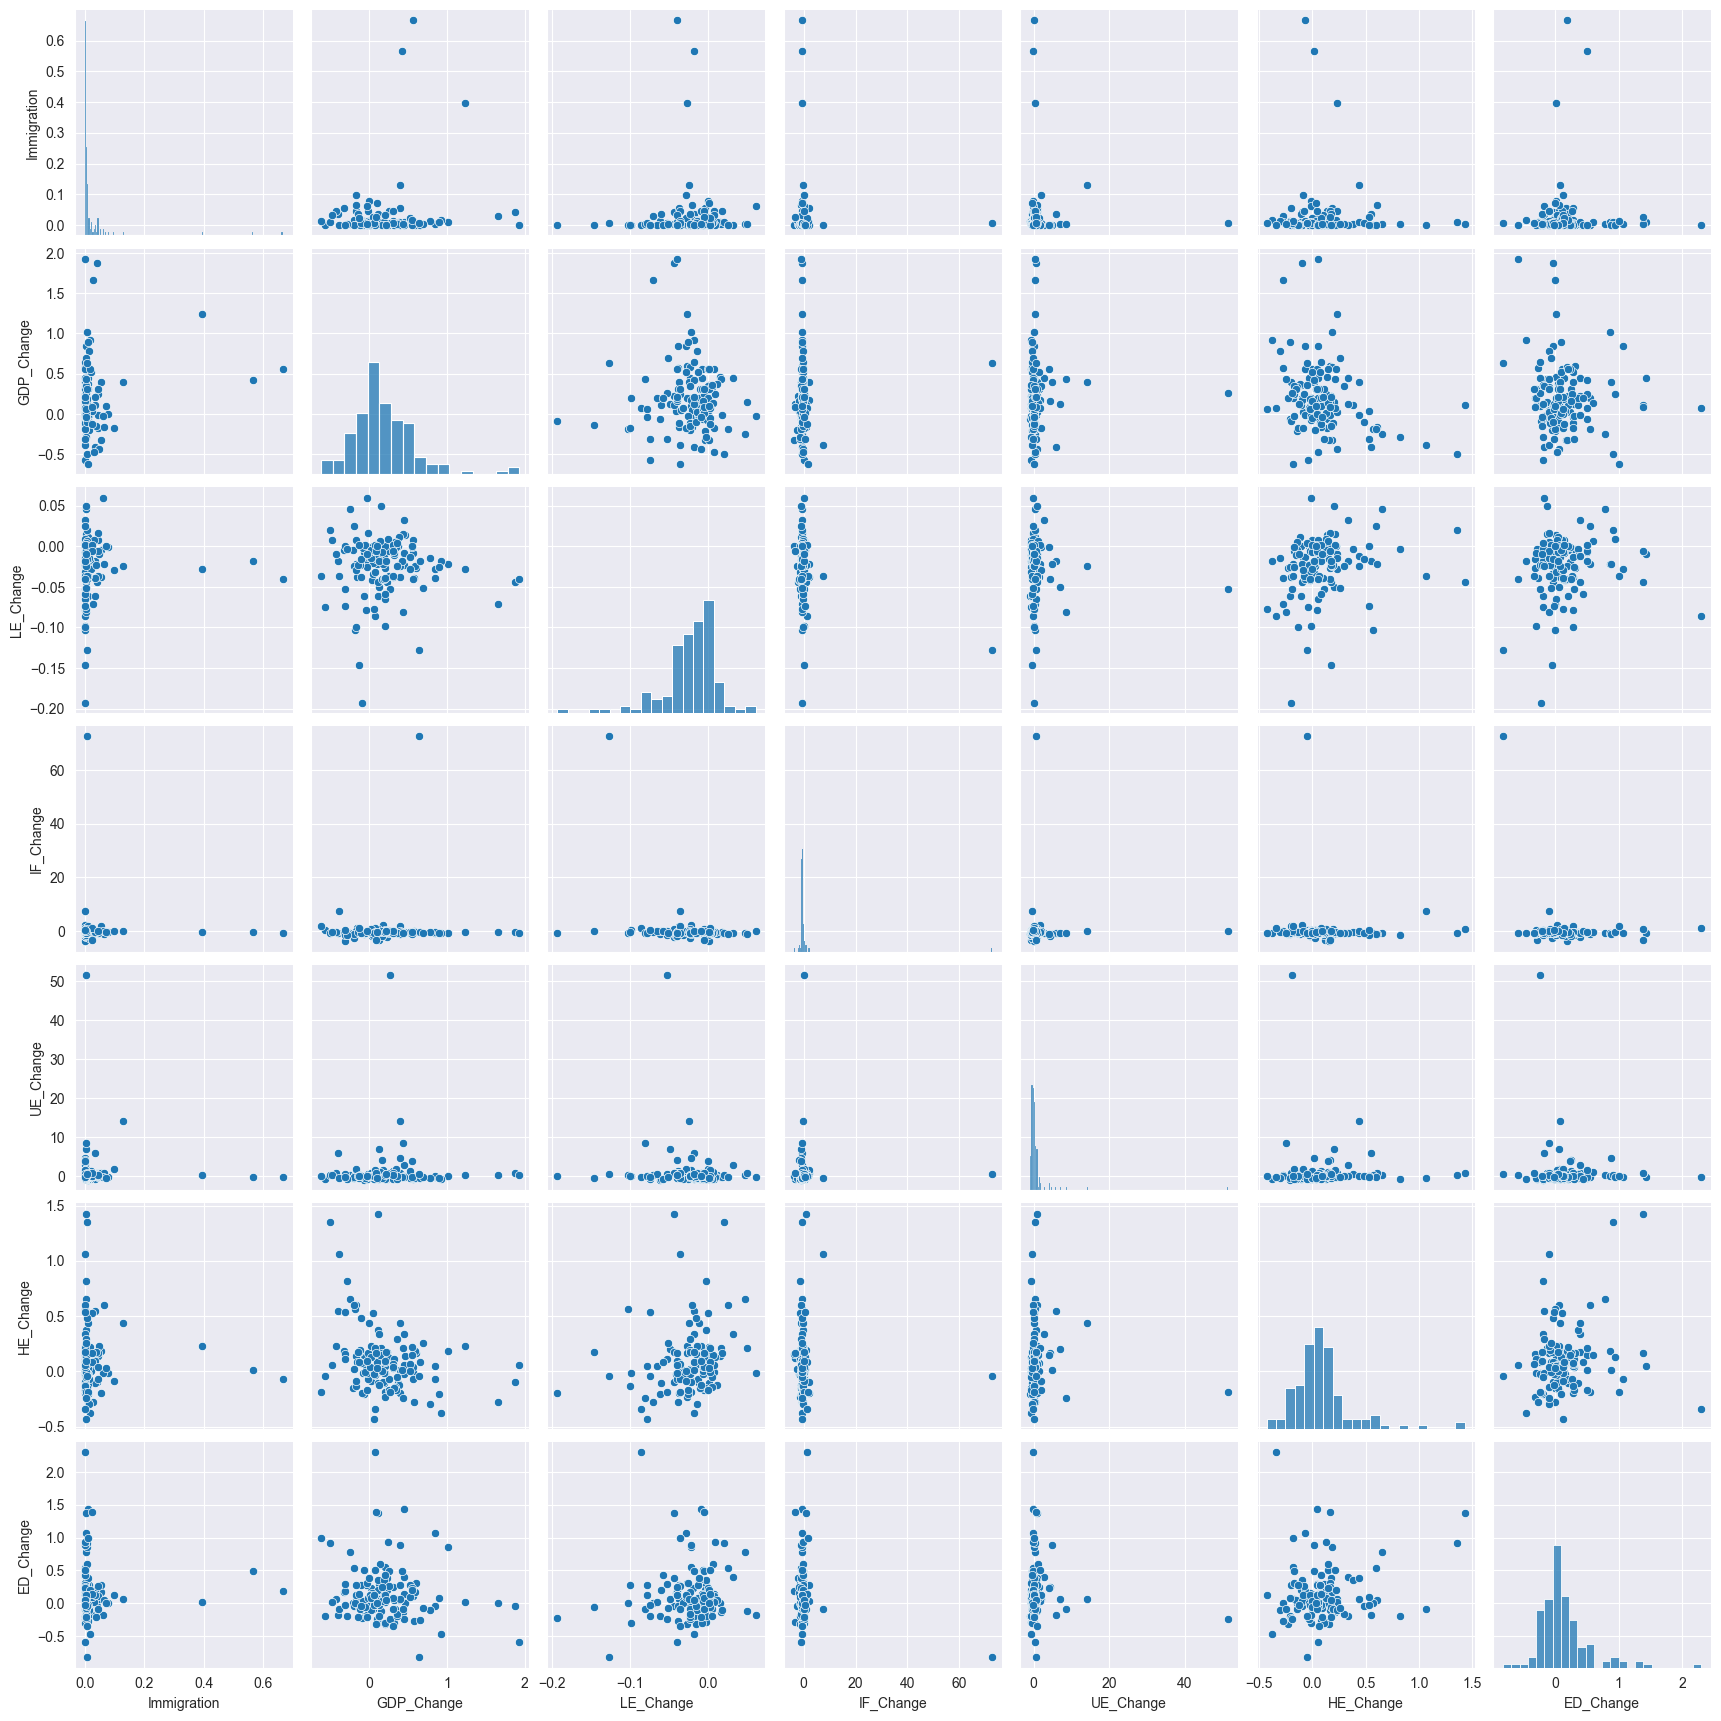

In [77]:
sb.pairplot(dataset)

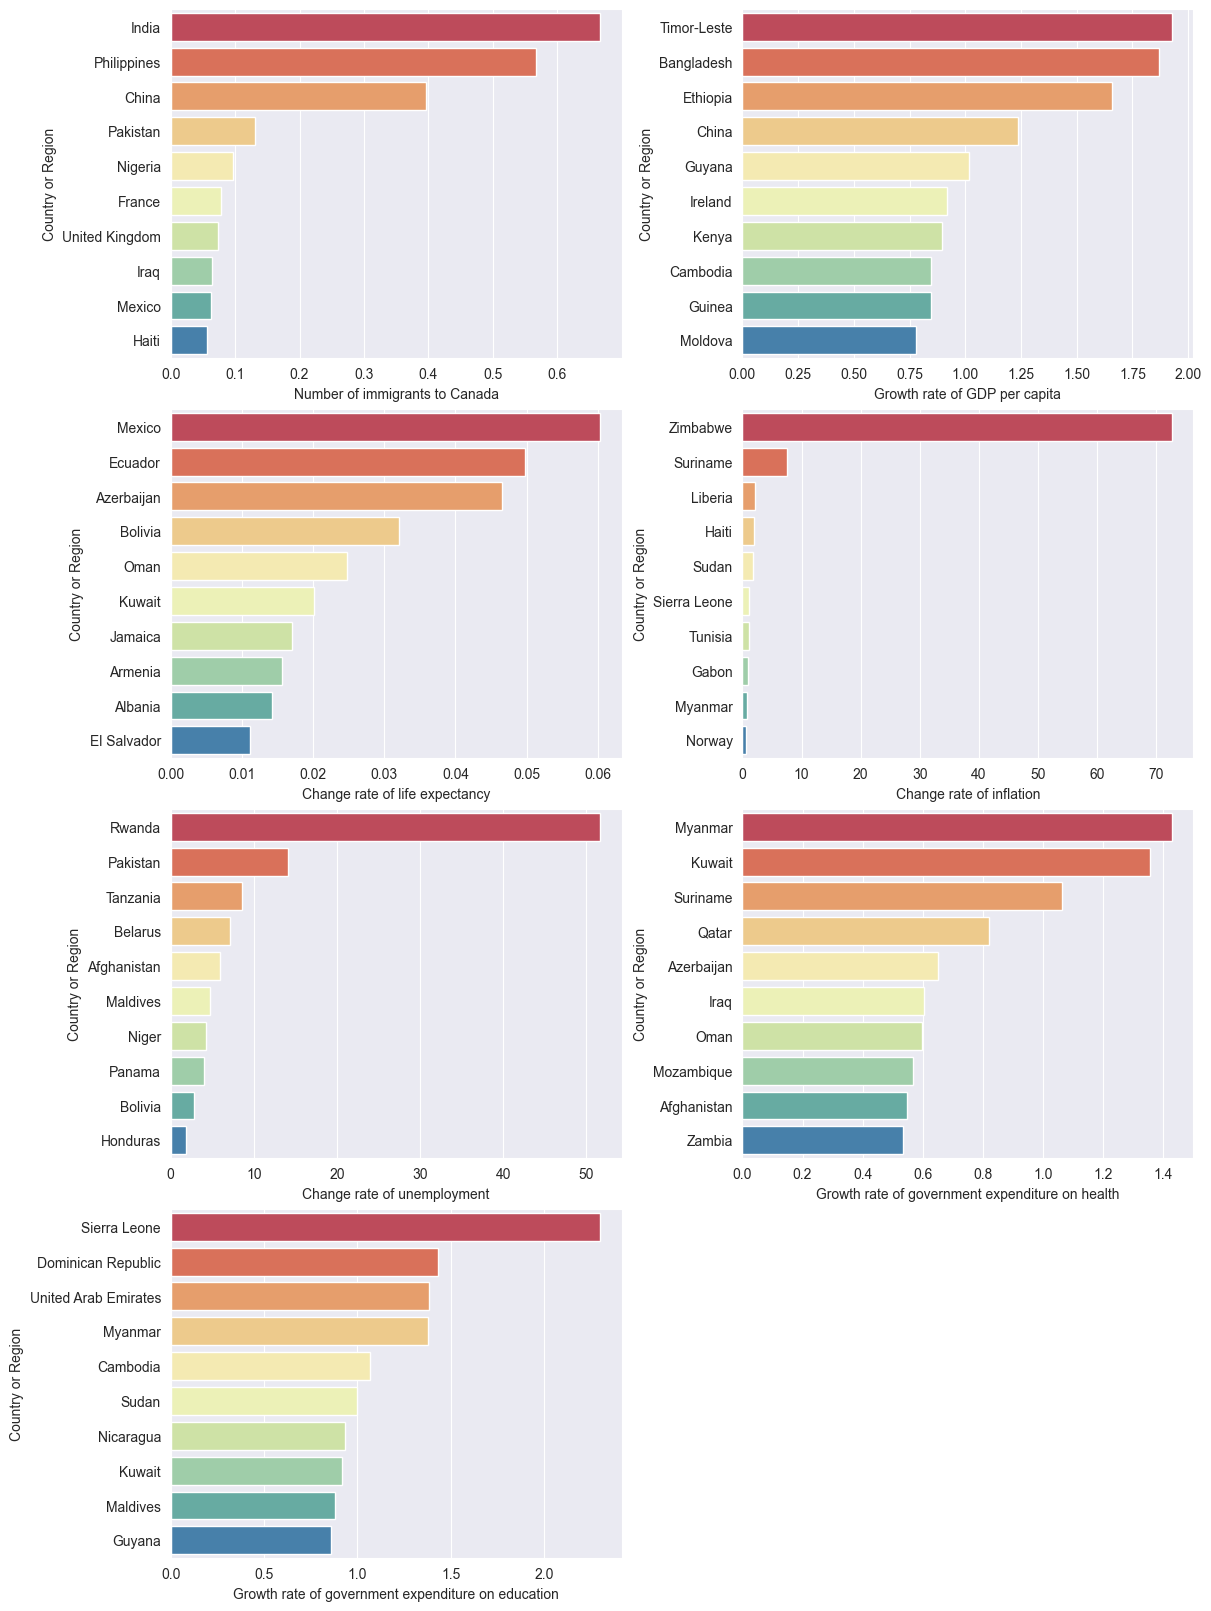

In [78]:
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')
sb.barplot(x='GDP_Change' ,y='Birthplace', data=dataset.nlargest(10, 'GDP_Change'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='Growth rate of GDP per capita', ylabel='Country or Region')
sb.barplot(x='LE_Change',y='Birthplace', data=dataset.nlargest(10, 'LE_Change'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Change rate of life expectancy', ylabel='Country or Region')
sb.barplot(x='IF_Change' ,y='Birthplace', data=dataset.nlargest(10, 'IF_Change'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Change rate of inflation', ylabel='Country or Region')
sb.barplot(x='UE_Change',y='Birthplace', data=dataset.nlargest(10, 'UE_Change'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Change rate of unemployment', ylabel='Country or Region')
sb.barplot(x='HE_Change' ,y='Birthplace', data=dataset.nlargest(10, 'HE_Change'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on health', ylabel='Country or Region')
sb.barplot(x='ED_Change',y='Birthplace', data=dataset.nlargest(10, 'ED_Change'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on education', ylabel='Country or Region')
fig.delaxes(axes[3,1])

2 clusters, the silhouette score is 0.5559346594893112
3 clusters, the silhouette score is 0.535805232040366
4 clusters, the silhouette score is 0.5111718801416021
5 clusters, the silhouette score is 0.5237143528436443
6 clusters, the silhouette score is 0.5453527084044364
7 clusters, the silhouette score is 0.5329566058277847
8 clusters, the silhouette score is 0.5191679244773418
9 clusters, the silhouette score is 0.5170508260376817


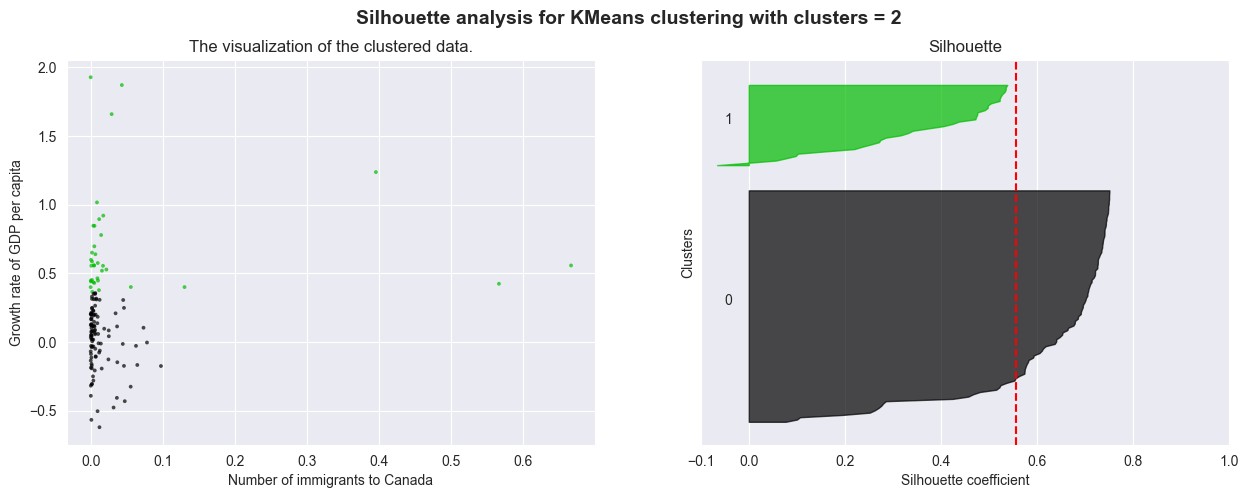

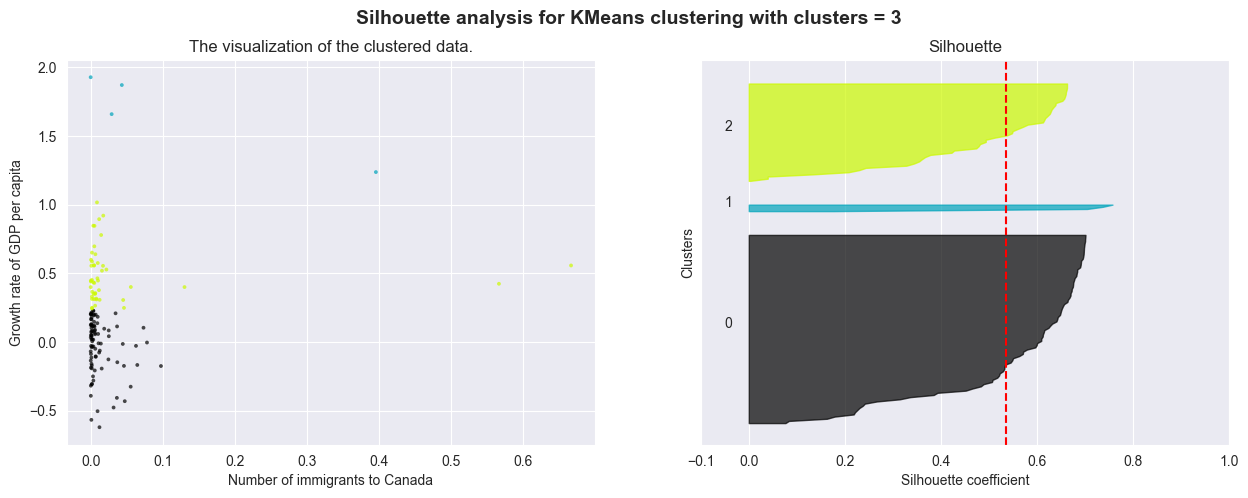

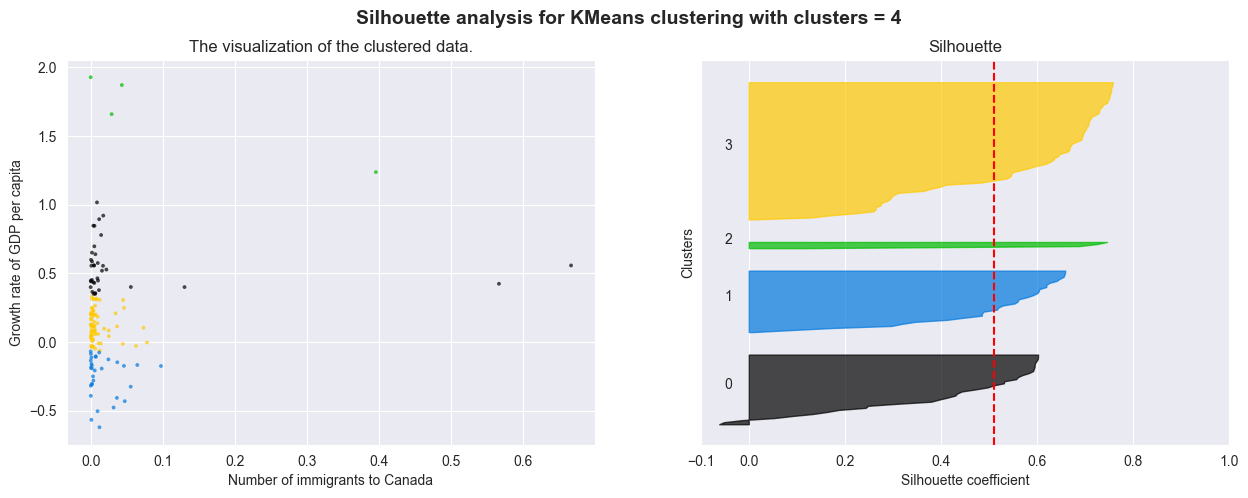

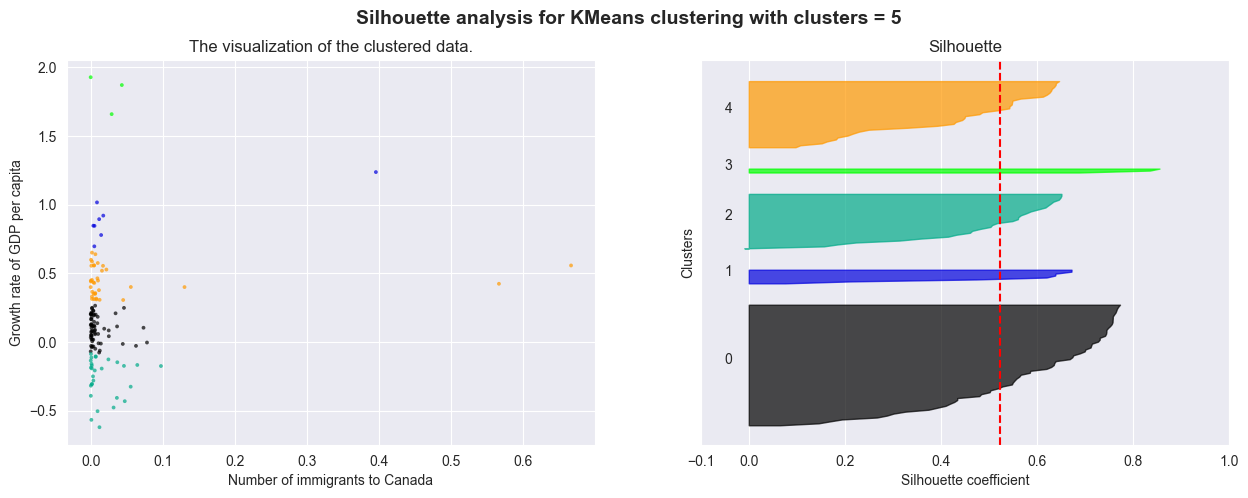

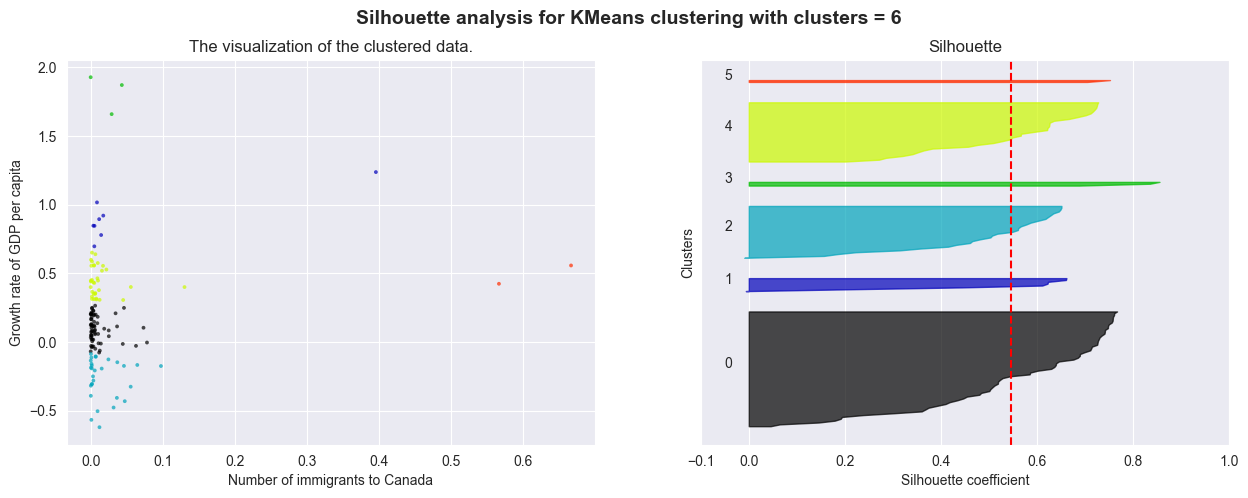

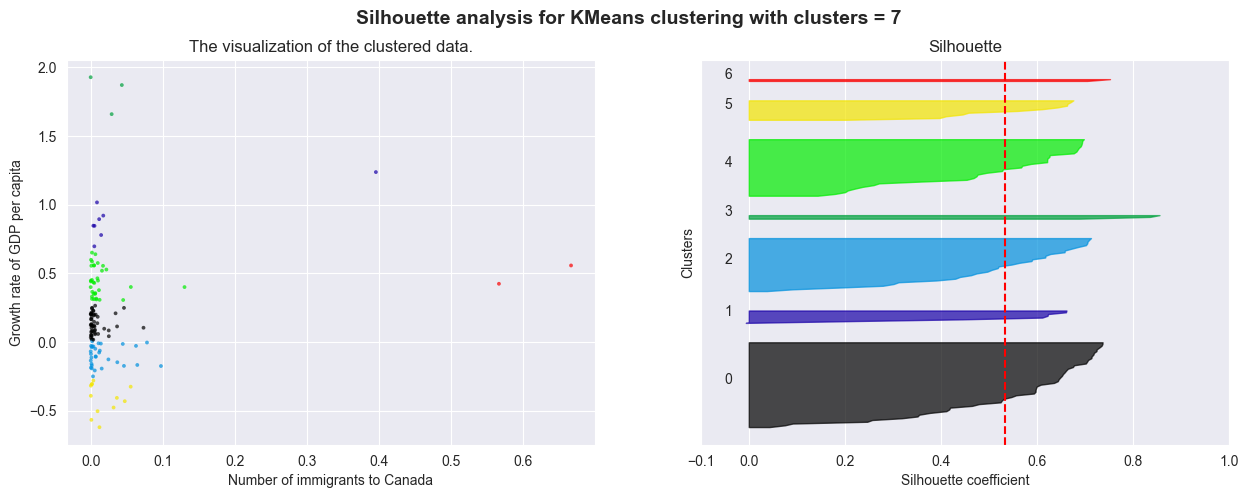

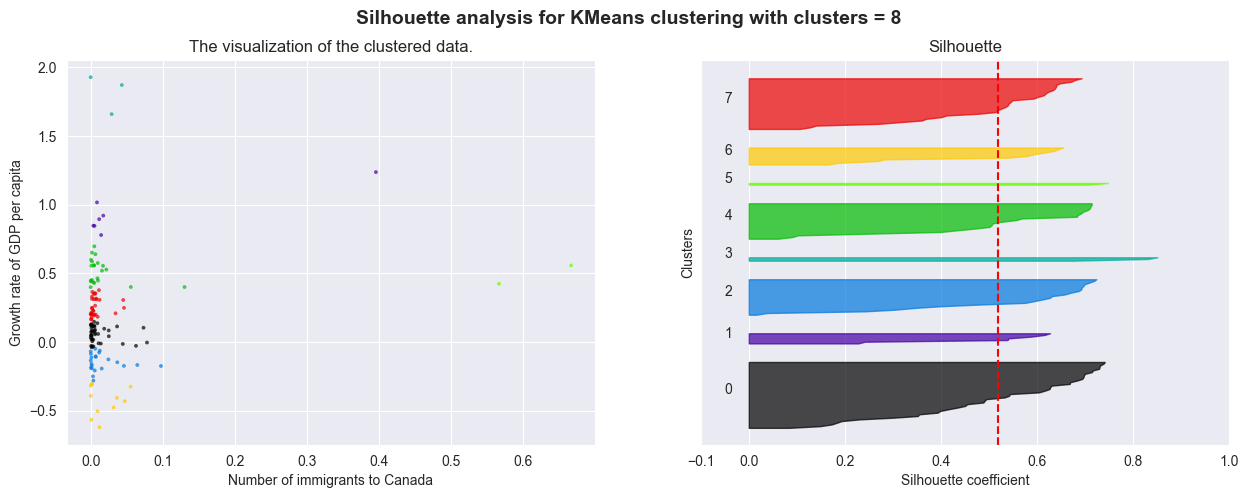

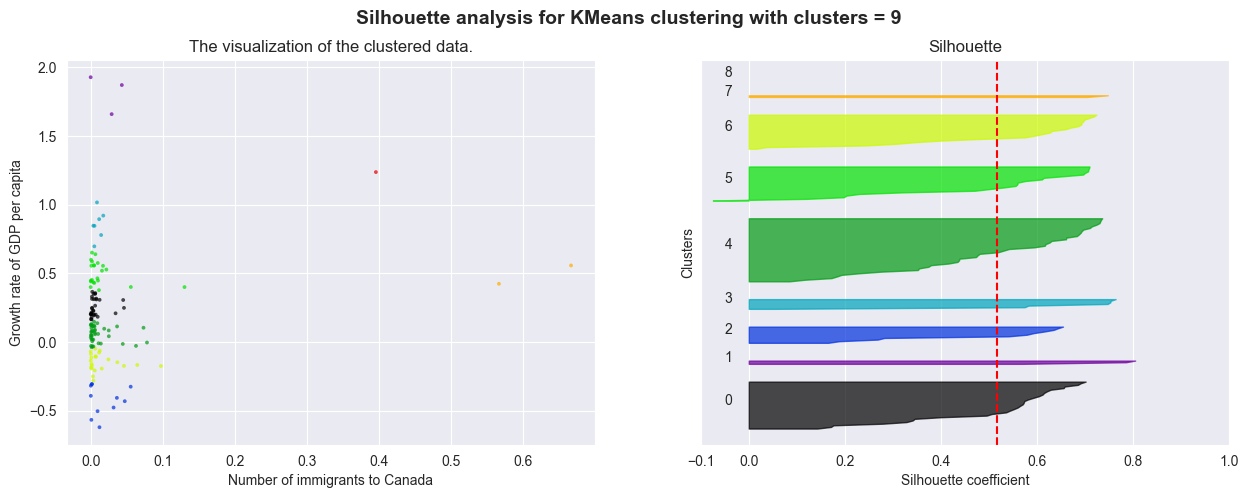

In [79]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
for i in range(2, 10):
    X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':c}).to_numpy()
    c1 = KMeans(n_clusters=i, random_state=0, n_init=10)
    label1 = c1.fit_predict(X1)
    silhouette = silhouette_score(X1, label1)
    print(i, 'clusters, the silhouette score is', silhouette)

    sample_silhouette = silhouette_samples(X1, label1)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(X1) + (i + 1) * 10])

    y_lower = 10
    for n in range(i):
        cluster_silhouette_values = sample_silhouette[label1 == n]
        cluster_silhouette_values.sort()

        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size

        color = cm.nipy_spectral(n / i)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax2.text(-0.05, y_lower + 0.5 * cluster_size, str(n))
        y_lower = y_upper + 10

    ax2.set_title("Silhouette")
    ax2.set_xlabel("Silhouette coefficient")
    ax2.set_ylabel("Clusters")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette, color="red", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(label1.astype(float) / i)
    ax1.scatter(X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax1.set_title("The visualization of the clustered data.")
    ax1.set_xlabel("Number of immigrants to Canada")
    ax1.set_ylabel("Growth rate of GDP per capita")
    plt.suptitle("Silhouette analysis for KMeans clustering with clusters = %d" % i, fontsize=14, fontweight="bold",)

plt.show()

In [80]:
def choose_cluster(table):
    score = 0
    n = 0
    for i in range(2, 10):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)
        if sil > score:
            score = sil
            n = i
    print(n, 'clusters, the silhouette score is', score)
    return n

def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []
        for k in range(len(a)):
            if cx[k] == j:
                group.append(a[k])
        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Number of immigrants to Canada')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.9088604869343969
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritan

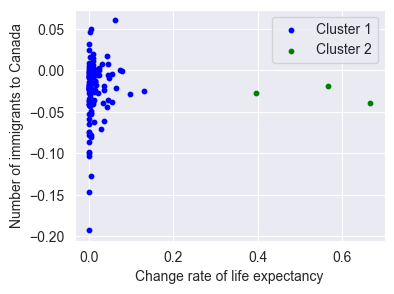

In [81]:
X2 = pd.DataFrame({'Immigration':nor[0][:], 'LE_Change':d}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Change rate of life expectancy')

2 clusters, the silhouette score is 0.9805500085303351
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

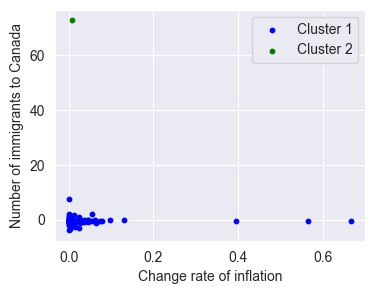

In [82]:
X3 = pd.DataFrame({'Immigration':nor[0][:], 'IF_Change':e}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Change rate of inflation')

2 clusters, the silhouette score is 0.9666226850269843
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

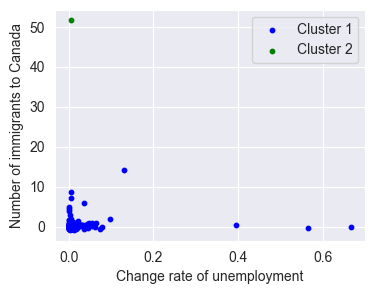

In [83]:
X4 = pd.DataFrame({'Immigration':nor[0][:], 'UE_Change':f}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Change rate of unemployment')

2 clusters, the silhouette score is 0.6820200640760807
Cluster 1: ['Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mexico', 'Moldova', 'Mongolia', 

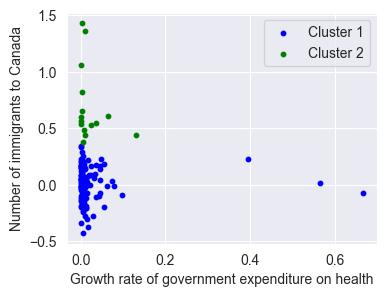

In [84]:
X5 = pd.DataFrame({'Immigration':nor[0][:], 'HE_Change':g}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Growth rate of government expenditure on health')

2 clusters, the silhouette score is 0.7180244089964208
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 

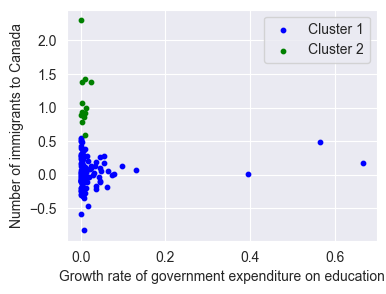

In [85]:
X6 = pd.DataFrame({'Immigration':nor[0][:], 'ED_Change':h}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Growth rate of government expenditure on education')

2 clusters, the silhouette score is 0.9549941550573862
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

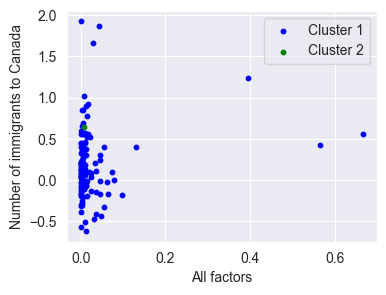

In [92]:
X7 = dataset.drop(['Birthplace'], axis=1).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'All factors')

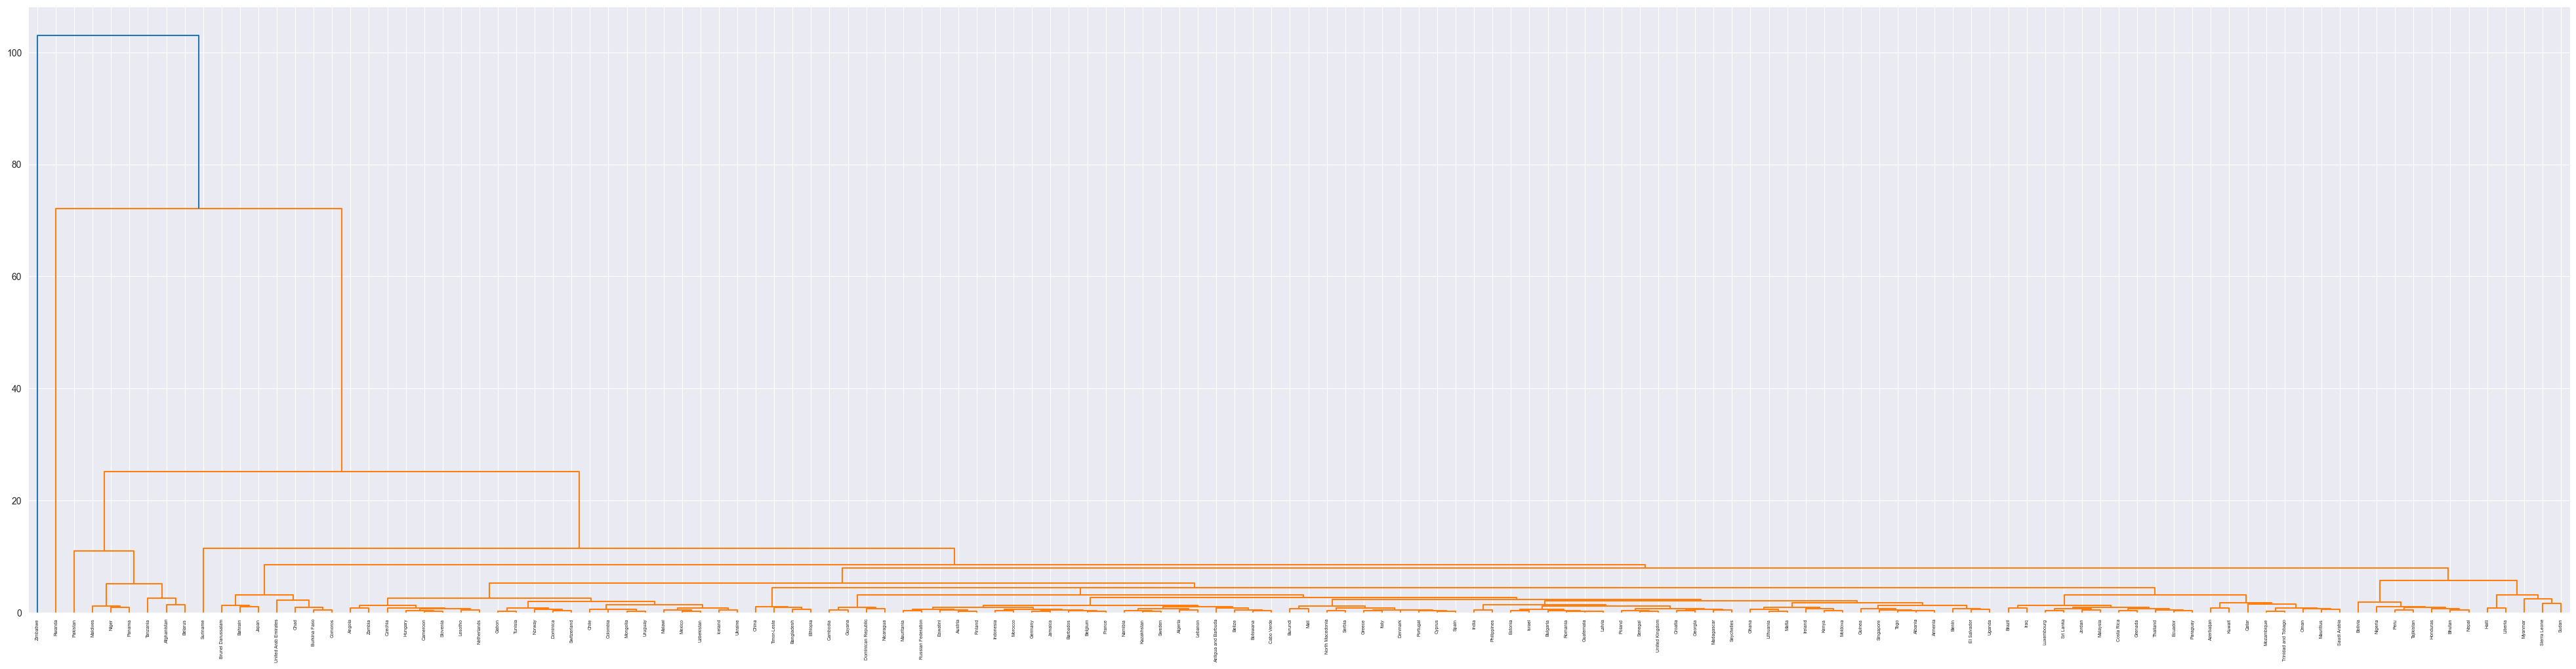

In [97]:
comb_data = dataset.drop(['Birthplace'], axis=1)
plt.figure(figsize=(50, 12))
dend=sch.dendrogram(sch.linkage(comb_data,method='ward'), labels=a)